In [1]:
from torch import Tensor
#from torch import LongTensor
import torch
import math
from matplotlib import pyplot as plt
#import baseline

DEBUG = False
%load_ext autoreload

%autoreload 2
%matplotlib inline

## Generate dataset:

In [2]:
1/math.sqrt(2*math.pi)

0.3989422804014327

In [3]:
def generate_disc_set(nb):
    input_ = Tensor(nb, 2).uniform_(0,1)
    disk_center = Tensor(nb, 2).fill_(0.5)
    #ones_ = torch.ones(nb,2)
    R = 1/math.sqrt(2*math.pi) # Radius of the disk
    target = (R - (disk_center - input_).pow(2).sum(1).sqrt()  ).sign()#.long()
    target.add_(1).div_(2) # to transform [-1,1] into [0,1]
    #target = input.pow(2).sum(1).mul(-1).add(1 / 2/ math.pi).sign().add(1).div(2).long() # prof version
    return input_, target


train_input, train_target = generate_disc_set(1000)
test_input, test_target = generate_disc_set(1000)

mu, std = train_input.mean(),train_input.std()
train_input.sub_(mu).div_(std)
mu, std = test_input.mean(),test_input.std()
test_input.sub_(mu).div_(std)

# one hot?
#one_hot_targets = np.eye(2)[train_target]
#train_target = one_hot_targets
#train_target = Tensor(train_target)


mini_batch_size = 100
print (train_input.size(), train_target.size())
#print(train_input[0:10],train_target[0:10])
print(train_target.size())
#plt.plot(train_input.where())
print(train_target[0])

torch.Size([1000, 2]) torch.Size([1000, 1])
torch.Size([1000, 1])

 0
[torch.FloatTensor of size 1]



In [4]:
train_target_ori  = train_target.clone()
one_hot_targets = torch.cat((train_target,1-train_target),1)
one_hot_targets[0]
train_target = one_hot_targets

#samples:        torch.Size([1000, 2])
#true_samples:   torch.Size([488, 2])
#false_samples:  torch.Size([512, 2])


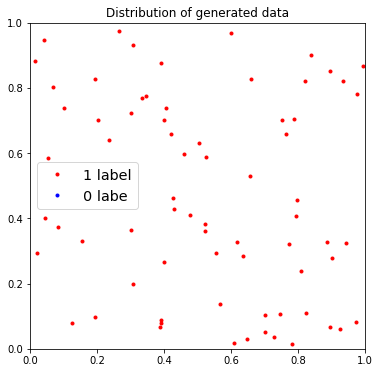

In [5]:
#third_tensor = torch.cat((first_tensor, second_tensor), 0)
def plot_data(input_, target_, figure_size = 6):
    input_true = torch.Tensor(0,2)
    input_false = torch.Tensor(0,2)
    for i,x in enumerate(input_):
        if target_[i][0] == 0 :
            input_false = torch.cat( (input_false, input_[i,:].view(-1,2)),0 )
        else :
            input_true = torch.cat( (input_true, input_[i,:].view(-1,2)),0 )
    print ('#samples:       ',input_.size())
    print ('#true_samples:  ',input_true.size())
    print ('#false_samples: ',input_false.size())
    p1 = plt.figure(1,figsize=(figure_size,figure_size))
    plt.plot(input_true[:,0].numpy(),input_true[:,1].numpy(),'r.',label='1 label')
    plt.plot(input_false[:,0].numpy(),input_false[:,1].numpy(),'b.',label='0 labe')
    plt.xlim(0,1), plt.ylim(0,1)
    plt.legend(fontsize='x-large')
    plt.title('Distribution of generated data')
plot_data(train_input, train_target)

Between -1,1 :

In [6]:
train_target=(train_target*2-1)

# Baseline

In [7]:
import baseline
baseline.baseline_linear_model(train_input, train_target_ori, test_input, test_target)

1.2 %


### Activation functions:

In [8]:
def tanh(x):
    return x.tanh()

def d_tanh(x):
    return (x.exp() + x.mul(-1).exp()).pow(-2)

def relu(x):
    if x>0 : return x
    else : return x.fill(0)
    
def d_relu(x):
    if x>0: return x.fill(1)
    else : return x.fill(0)

def mse(x,t):
    if DEBUG == True:
        print('mse x.size',x.size())
        print('mse target size',t.size())
    return (x - t).pow(2).sum()

#def dsigma_relu(x):

sigma = tanh
dsigma = d_tanh

### suggested structure:

In [102]:
class Module ( object ) :
    def forward ( self , * input ) :
        raise NotImplementedError
        
    def backward ( self , * gradwrtoutput ) :
        raise NotImplementedError
        
    def param ( self ) :
        return [] 
    
    def zero_grads ( self ) :
        pass
    
    def reset_params( self ) :
        pass
    

    
   # self._gradient.add_(d_dy.view(-1,1)*self._input.view(1,-1))        
    
"""def backward_pass(w1, b1, w2, b2,
              t,
              x, s1, x1, s2, x2,
              dl_dw1, dl_db1, dl_dw2, dl_db2):
    x0 = x
    dl_dx2 = dloss(x2, t)
    dl_ds2 = dsigma(s2) * dl_dx2
    dl_dx1 = w2.t().mv(dl_ds2)
    dl_ds1 = dsigma(s1) * dl_dx1

    dl_dw2.add_(dl_ds2.view(-1, 1).mm(x1.view(1, -1)))
    dl_db2.add_(dl_ds2)
    dl_dw1.add_(dl_ds1.view(-1, 1).mm(x0.view(1, -1)))
    dl_db1.add_(dl_ds1)"""

class Tanh(Module):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        self.input = input
        return self.input.clone().tanh()
    
    def backward(self, d_output):
        x = self.input
        #(1 - self._input.tanh()**2) * d_dy
        d_input = (1 - self.input.tanh()**2)*d_output#d_tanh(x) * d_output
        return d_input
     


class LossMSE(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self,x,t):
        self.input=x
        self.target = t
        d_input = mse(x,t)
        return d_input
        
    def backward(self):
        d_output = 2 * (self.input - self.target)
        return d_output
    
class Sequential(Module):

    def __init__(self,modules, loss):
        super().__init__()
        self.modules = modules
        self.loss = loss
        
    
    #done by luca
    def add(self, module):
        self.modules.append(module)

    def forward(self, input, target):
        for module in self.modules:
            input = module.forward(input) # module.forward?
        return input, self.loss.forward(input, target)
    
    def backward(self):
        out = self.loss.backward()# arguments??
        n = len(self.modules)-1 # -1 for the loss?
        for i in range(0,n):
            out = self.modules[n-i].backward(out)
        return out
    
    def zero_grads(self):
        for x in self.modules:
            x.zero_grads()
            
    def param ( self ):
        params = []
        for x in self.modules:
            params = params + x.param()
        return params
            
            
class Linear(Module):
    
    def __init__(self, in_features, out_features):
        super().__init__()
        # num features
        self.in_features = in_features
        self.out_features = out_features
        # weigths
        self.weight = torch.Tensor(out_features, in_features).normal_(0,1e-6)
        self.bias   = torch.Tensor(out_features).fill_(0.0)
        # gradients
        self.dl_dws = torch.Tensor(out_features, in_features).fill_(0.0)
        self.dl_dbias   = torch.Tensor(out_features).fill_(0.0)
        self.params = [(self.weight,self.dl_dws), (self.bias, self.dl_dbias)] 
        if DEBUG == True:
            print('weights size: ',self.weight.size())
        # initialize the parameters
        #self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1)) # *sqrt(3)?
        self.weight.uniform_(-stdv, stdv)
        self.bias.uniform_(0, 0)
        
    def zero_grads(self):
        """resets the gradients of the module"""
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.dl_dws.zero_()
        self.dl_dbias.zero_()

    def forward(self, input):
        self.input = input
        self.s = torch.mv(self.weight, input).add(self.bias)
        if DEBUG == True:
            print(input.size())
        #self.input = torch.add(self.input,self.bias)
        return self.s.clone()
        
    def backward ( self ,d_output ) :
        if DEBUG == True:
            print('input: ',self.input.view(-1,1).size())
            print('output: ',d_output.view(-1,1).t().size())
        dl_dw = d_output.view(-1,1).mm(self.input.view(-1,1).t())
        if DEBUG == True:
            print('dl_dw size: ',dl_dw.size())
            print('dl_dws size',self.dl_dws.size())
        self.dl_dws.add_(dl_dw) 
        self.dl_dbias.add(d_output)
        d_input = self.weight.t().mv(d_output) #mv()
        return d_input
    
    def param ( self ) :
        return [[self.weight,self.dl_dws], [self.bias, self.dl_dbias]] 
    
    

In [103]:
hidden = 20
lay1 = Linear(2,hidden)
sigma1 = Tanh()
lay2 = Linear(hidden,hidden)
sigma2 = Tanh()
lay3 = Linear(hidden,2)
sigma3 = Tanh()
layers = [lay1,sigma1, lay2, sigma2, lay3, sigma3]
net = Sequential(modules = layers, loss = LossMSE())

In [104]:
print(train_input[0])
print(Tensor([0.2 , 0.3]))
print(train_target[0])
print(Tensor([-1,1]))

a = net.forward(Tensor([0.2 , 0.3]),Tensor([-1,1]))
a

net.backward()
net.zero_grads()

a = (1,2)
a[0]

lr = 0.1



 1.6696
-1.3786
[torch.FloatTensor of size 2]


 0.2000
 0.3000
[torch.FloatTensor of size 2]


-1
 1
[torch.FloatTensor of size 2]


-1
 1
[torch.FloatTensor of size 2]



In [105]:
train_target[0]


-1
 1
[torch.FloatTensor of size 2]

# TEST

In [106]:
DEBUG = False
# training set
train_input = train_input
train_target = train_target

# network parameters
model = Sequential(modules = layers, loss= LossMSE())

mini_batch_size = 1
# training parameters
lr = 1
nb_epochs = 40
train_errors = []
loss_list = []

for epoch in range(nb_epochs):

    # Back-prop

    acc_loss = 0
    nb_train_errors = 0
    
    model.zero_grads()
    
    #for b in range(0,train_input.size(0), mini_batch_size):
    for b in range(0,train_input.size(0)):
        #output, loss = model.forward(train_input[b:b+mini_batch_size],train_target[b:b+mini_batch_size])
        output, loss = model.forward(train_input[b],train_target[b])
        acc_loss += loss
        model.backward()
        #print('OUTPUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUT: ',output)
        value_pred, prediction = output.max(0)
        #print(prediction)
        value_target, target = train_target[b].max(0)
        #print(target)
        
        if target.numpy() != prediction.numpy():
            nb_train_errors = nb_train_errors + 1 
        
    train_errors.append(nb_train_errors)
    loss_list.append(acc_loss)
    my_parameters = model.param()
    if DEBUG == True:
        print('length params', len(my_parameters))
        print('weigths before',my_parameters[0][0][0:5])
        print('DDDweigths before',my_parameters[0][1][0:5])
    for i,_ in enumerate(my_parameters):
        my_parameters[i][0]-= lr * my_parameters[i][1]
    if DEBUG == True:
        print('weigths after',my_parameters[0][0][0:5])
        print('DDDweigths after',my_parameters[0][1][0:5])
    print(model.param()[0][1][0:5])
    
    print('epoch {:d} acc_train_loss {:.02f} acc_train_error {:.02f}%'.format(epoch,acc_loss,
                              (100 * nb_train_errors) / train_input.size(0)))
     




 0  0
 0  0
 0  0
 0  0
 0  0
[torch.FloatTensor of size 5x2]

epoch 0 acc_train_loss 2000.00 acc_train_error 51.40%

 0  0
 0  0
 0  0
 0  0
 0  0
[torch.FloatTensor of size 5x2]

epoch 1 acc_train_loss 2000.00 acc_train_error 51.40%

 0  0
 0  0
 0  0
 0  0
 0  0
[torch.FloatTensor of size 5x2]

epoch 2 acc_train_loss 2000.00 acc_train_error 51.40%

 0  0
 0  0
 0  0
 0  0
 0  0
[torch.FloatTensor of size 5x2]

epoch 3 acc_train_loss 2000.00 acc_train_error 51.40%

 0  0
 0  0
 0  0
 0  0
 0  0
[torch.FloatTensor of size 5x2]

epoch 4 acc_train_loss 2000.00 acc_train_error 51.40%

 0  0
 0  0
 0  0
 0  0
 0  0
[torch.FloatTensor of size 5x2]

epoch 5 acc_train_loss 2000.00 acc_train_error 51.50%

 0  0
 0  0
 0  0
 0  0
 0  0
[torch.FloatTensor of size 5x2]

epoch 6 acc_train_loss 2000.00 acc_train_error 51.50%

 0  0
 0  0
 0  0
 0  0
 0  0
[torch.FloatTensor of size 5x2]

epoch 7 acc_train_loss 2000.00 acc_train_error 51.50%

 0  0
 0  0
 0  0
 0  0
 0  0
[torch.FloatTensor of siz

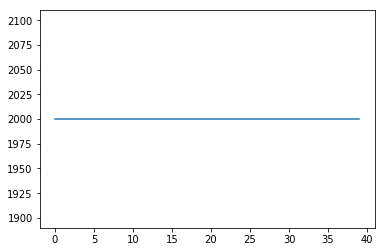

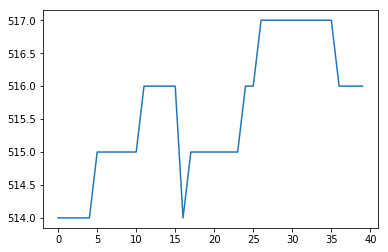

In [107]:
plt.plot(loss_list)
plt.show()
plt.plot(train_errors)
plt.show()

In [108]:
# prof version

######################################################################

def loss(v, t):
    return (v - t).pow(2).sum()

def dloss(v, t):
    return 2 * (v - t)

######################################################################
# from F
class Model(Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 20, 5)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        return F.relu(self.conv2(x))

def linear(input, weight, bias=None):
    
    output = input.matmul(weight.t())
    if bias is not None:
        output += bias
    return output


class Linear(Module):
    
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        return F.linear(input, self.weight, self.bias)

######################################################################
################# A first model ######################################
def linear_forward(x,w,b):
    s = w.mv(x) + b
    x = sigma(s)
    return s,x

def linear_backward(x0, x, dl_ds_prev, dl_dw, dl_db, initial = False):
    
    dl_dx = w.t().mv(dl_ds_prev)
    dl_ds = dsigma(s1) * dl_dx   
    dl_dw.add_(dl_ds.view(-1, 1).mm(x0.view(1, -1)))
    dl_db.add_(dl_ds)

def forward_pass(ws, bs, x, test = False):
    x0 = x
    
    s1, x1 = linear_forward(x0,ws[0],bs[0])
    s2, x2 = linear_forward(x1,ws[1],bs[1])
    
    xs = [x1, x2]
    ss = [s1, s2]
    if test: 
        return xs[-1]
    return x0, xs, ss


def backward_pass(ws, bs,
                  t,
                  x, xs, ss,
                  dl_dws, dl_dbs):
    x0 = x
    
    dl_dx2 = dloss(xs[-1], t)
    dl_ds2 = dsigma(ss[2-1]) * dl_dx2
    dl_dws[2-1].add_(dl_ds2.view(-1, 1).mm(xs[1-1].view(1, -1)))
    dl_dbs[2-1].add_(dl_ds2)
    
    dl_dx1 = ws[2-1].t().mv(dl_ds2) # w2
    dl_ds1 = dsigma(ss[1-1]) * dl_dx1   
    
    dl_dws[1-1].add_(dl_ds1.view(-1, 1).mm(x0.view(1, -1)))
    dl_dbs[1-1].add_(dl_ds1)

# Training:

In [23]:


zeta = 0.9
train_input = train_input
test_input = test_input

nb_hidden=50
print ('train_input.size(): ', train_input.size())
nb_classes = 2 #train_target.size(1) 
nb_train_samples = train_input.size(0)

eta = 0.1 / train_target.size(0)

eps = 1e-6

# weights and biases
w1 = Tensor(nb_hidden, train_input.size(1)).normal_(0,1)
b1 = Tensor(nb_hidden).normal_(0,1)
w2 = Tensor(nb_classes, nb_hidden).normal_(0,eps)
b2 = Tensor(nb_classes).normal_(0,eps)

# lists
ws = [w1, w2]
bs = [b1, b2]
# derivatives of the losse wrt weights and biases
dl_dws = []
dl_dbs = []
for w in ws:
    dl_dws.append(Tensor(w.size()))
for b in bs:
    dl_dbs.append(Tensor(b.size()))


epochs = 250
for k in range (0,epochs):
    
    acc_loss = 0
    nb_train_errors = 0
    
    # set the storage to 0
    for i in range(0, len(dl_dws)):
        dl_dws[i].zero_()
        dl_dbs[i].zero_()
    
    # for each sample run forward and backward pass
    for n in range(0, nb_train_samples):
        
        # run forward pass
        x0, xs, ss = forward_pass(ws, bs, train_input[n])
        
        # prediction is the maximum predicted class
        
        predicted = xs[-1].max(dim = 0)[1] # dim is the axis, 1 for taking index, 0 to just select the value
        pred = predicted [0]
        #print(predicted)
        pred = xs[-1][0]
        #print(xs[-1])
        print(pred)
        # check wether the target was 1 or -1 --> verify if positif
        if train_target[n] != int(pred) : 
            nb_train_errors = nb_train_errors + 1 # if == -1 lets say :p 
        acc_loss += loss(Tensor(1).fill_(pred), train_target[n])
        #acc_loss += loss(pred, train_target[n])

        # run backward pass
        backward_pass(ws, bs,
                      train_target[n],
                      x0, xs, ss,
                      dl_dws, dl_dbs)
    
    # Gradient step
    for i in range(0, len(ws)):
        ws[i] = ws[i] - eta * dl_dws[i]
        bs[i] = bs[i] - eta * dl_dbs[i]

    # Test error
    nb_test_errors = 0
    for n in range(0, test_input.size(0)):
        output = forward_pass(ws, bs, test_input[n], test=True)

        pred = output.max(0)[1][0]
        if test_target[n] != int(output[0]) : nb_test_errors = nb_test_errors + 1  


    print(k,' --> acc_train_loss {:.02f} acc_train_error {:.02f}% test_error {:.02f}%'
          .format(acc_loss,
                  (100 * nb_train_errors) / train_input.size(0),
                  (100 * nb_test_errors) / test_input.size(0)))

train_input.size():  torch.Size([1000, 2])
-6.00436487729894e-06


RuntimeError: bool value of non-empty torch.ByteTensor objects is ambiguous